In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from matplotlib.colors import Normalize
import cv2
import tqdm
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import ImageGrid

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
new_resolution = (2,2,2)
templates = {}
for brain_name in ["luke_exp", "luke_raw", "FDA", "JRC2018"]:
    templates[brain_name] = brainsss.load_template_brain(brain_name, new_resolution)

Loaded Luke Exp
Loaded Luke Raw
Loaded FDA
Loaded JRC2018


In [37]:
### this is how we get from luke space to FDA space
exp2jrc = ants.registration(templates["JRC2018"], templates["luke_exp"], type_of_transform='Affine')

In [174]:
### load sama meanbrain
file = '/oak/stanford/groups/trc/data/berger/registration/meanbrain_building/sama_local_meanbrain_mirror/templates/syn_3.nii'
file = '/oak/stanford/groups/trc/data/berger/registration/meanbrain_building/sama_local_meanbrain_mirror/preprocessed/220517_1_local_atlas.nii'
sama = ants.image_read(file)
sama.shape

(1024, 700, 249)

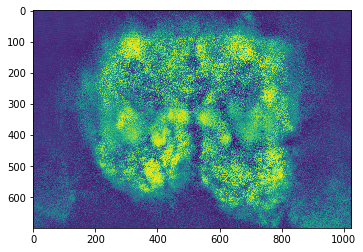

In [191]:
plt.imshow(sama[:,:,100].T)

In [192]:
### crop down to remove "empty" regions that are not empty on FDA
sama = sama[250:-250,200:-200,60:110]

In [194]:
sama = ants.from_numpy(sama)
sama.set_spacing((.5,.5,.5)) # this is wrong just making something up

In [195]:
### make 2um moving
moving_2um = ants.resample_image(sama,(2,2,2),use_voxels=False)
moving_2um.shape

(131, 75, 13)

In [196]:
### width of subvol comes directly from subvol
# r="radius", o="original"
xr_o = int(np.ceil(moving_2um.shape[0]/2))
yr_o = int(np.ceil(moving_2um.shape[1]/2))
zr_o = int(np.ceil(moving_2um.shape[2]/2))
print(xr_o,yr_o,zr_o)

66 38 7


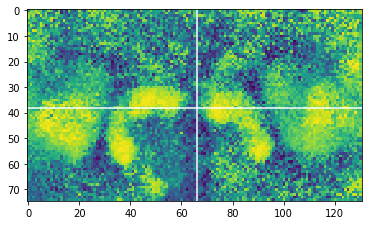

In [197]:
#plt.imshow(moving_2um[:,:,30].T)
plt.imshow(moving_2um[:,:,zr_o].T)
plt.axvline(xr_o,color='w')
plt.axhline(yr_o,color='w')

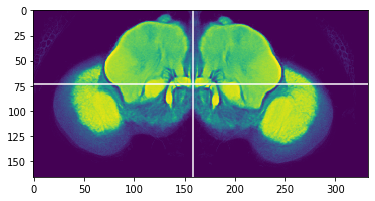

In [214]:
### estimate center of moving on luke_raw

xc = 158
yc = 73
zc = 30

plt.imshow(templates["luke_raw"][:,:,zc].T)
plt.axvline(xc,color='w')
plt.axhline(yc,color='w')

In [215]:
### Mask luke raw to the subvol

def newbox(c,r):
    return slice(*(np.clip(c-r,0,None),c+r))

new_box = []
for i,r in enumerate([xr_o,yr_o,zr_o]):
    new_box.append(int(r*moving_2um.spacing[i]/templates["luke_raw"].spacing[i]))
xr = new_box[0]
yr = new_box[1]
zr = new_box[2]

luke_raw_lowres_cropped = templates["luke_raw"][newbox(xc,xr),newbox(yc,yr),newbox(zc,zr)]
luke_raw_lowres_cropped = ants.from_numpy(luke_raw_lowres_cropped)
luke_raw_lowres_cropped.set_spacing(templates["luke_raw"].spacing)

luke_raw_lowres_padded = np.zeros((templates["luke_raw"].shape[0],templates["luke_raw"].shape[1],templates["luke_raw"].shape[2]))
luke_raw_lowres_padded[newbox(xc,xr),newbox(yc,yr),newbox(zc,zr)] = luke_raw_lowres_cropped.numpy()
luke_raw_lowres_padded = ants.from_numpy(luke_raw_lowres_padded)
luke_raw_lowres_padded.set_spacing(templates["luke_raw"].spacing)

In [216]:
### align subvol ("moving") to this padded luke_raw
# NOTE: THIS WARP STEP SOMETIMES LOOKS GOOD, SOMEIMES BAD, SO CHECK
subvol_to_lukeraw = ants.registration(luke_raw_lowres_padded, moving_2um, type_of_transform='SyN')

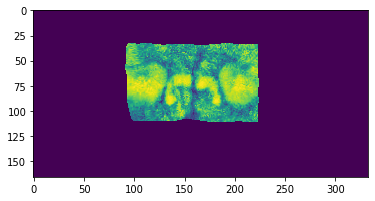

In [217]:
### this should look like luke_raw_lowres_cropped
plt.imshow(subvol_to_lukeraw['warpedmovout'][:,:,zc].T)

In [218]:
moving2FDA = ants.apply_transforms(fixed=templates["JRC2018"],
                                    moving=subvol_to_lukeraw['warpedmovout'],
                                    transformlist=exp2jrc['fwdtransforms'])

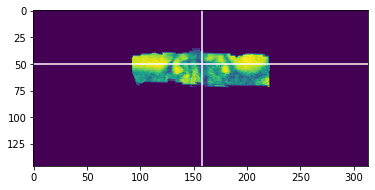

In [234]:
plt.imshow(moving2FDA[:,:,15].T)
plt.axhline(50,color='w')
plt.axvline(158,color='w')

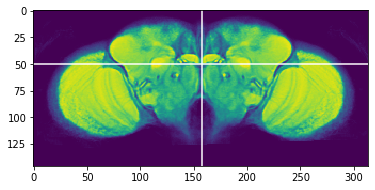

In [14]:
plt.imshow(templates["FDA"][:,:,15].T)
plt.axhline(50,color='w')
plt.axvline(158,color='w')

In [236]:
dir_ = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221216_sama_warp"
os.mkdir(dir_)

In [240]:
save_file = os.path.join(dir_,"fda_2um")
nib.Nifti1Image(templates["FDA"].numpy(), np.eye(4)).to_filename(save_file)

In [ ]:
#20221216_220517_1_local_atlas_to_FDA_ants

In [ ]:
#visualize added synthmorph

In [4]:
file = "/oak/stanford/groups/trc/data/berger/registration/for_luke/sama_local_individual_to_fda/aligned_us_0.nii"
brain = ants.image_read(file)

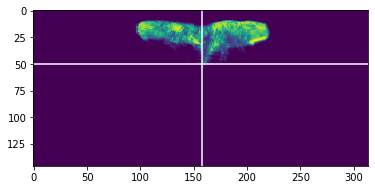

In [12]:
plt.imshow(brain[:,:,20].T)
plt.axhline(50,color='w')
plt.axvline(158,color='w')